# Machine Learning in Network Science
Group Challenge

***
by: Leonardo Basili, Paul Bédier, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers classical machine learning techniques, namely:
- unsupervised link prediction based on graph-topology (Adamic Adar, Preferential Attachment, Resource-Allocation-Index, ...)
- supervised link prediction using Logistic Regression, Bagging and Boosting

### 1. Import Packages

In [ ]:
from importlib import reload
reload(analyseData)
reload(prepData)
reload(loadData)
reload(modeling)
reload(autoenc)

In [4]:
# import own scripts
import util.analyse_Data as analyseData
import util.preprocess_Data as prepData
import util.load_Data as loadData
import util.modeling as modeling
import util.autoencoder as autoenc

In [1]:
# parse & handle data
import os
import csv
import numpy as np
import pandas as pd
import networkx as nx # graph data

# modeling
import torch
from torch_geometric.nn import GAE, VGAE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier

# hyperparameter tuning
from ray import tune, air
from ray.tune import CLIReporter, JupyterNotebookReporter
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler, MedianStoppingRule, PopulationBasedTraining
from ray.tune.stopper import MaximumIterationStopper
from ray.tune.experiment.trial import Trial
from ray.tune.sklearn import TuneSearchCV

# evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import PredefinedSplit, ShuffleSplit

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)   # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data for Modeling

In [5]:
# might take up to a minute
(G, G_train, node_info,
 train_tf, val_tf, trainval_tf,
 test, test_tf,
 X_train, y_train, X_val, y_val, X_trainval, y_trainval,
 X_test) = loadData.load_transform(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected
Enriching train data...
Enriching validation data...
Enriching test data...


In [6]:
# might take up to a minute
data, _ = autoenc.load(testing_ratio = 0.2)

Number of positive edges for training: 4174
Number of positive edges for validation: 1043
Number of edges in original graph: 5217
Number of edges in training graph: 4174
The graph is connected


In [7]:
# get node embeddings (IF YOU CHANGE SEED = 42, then you need to train new autoencoder as train-val split is different)

# load best autoencoder
path = os.path.abspath("")+"\\models\\autoencoder.pt"
model = VGAE(autoenc.Encoder(data.x.size()[1], 64, 1.5, 5, 0.2, 0.01))
model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

# get embeddings of nodes
embedding = autoenc.get_embeddings(model, data.x, data.trainval_edges)
node_emb = pd.DataFrame(embedding).rename(columns = {val: f"x{val+1}" for val in range(embedding.shape[1])})

# enrich train
train_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.train_edges)).rename(columns = {0: "sim"})
train_tf = (train_tf
    .assign(sim = train_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich val
val_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.train_pos_edges, data.val_edges)).rename(columns = {0: "sim"})
val_tf = (val_tf
    .assign(sim = val_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# enrich test
test_sim = pd.DataFrame(autoenc.get_similarity(model, data.x, data.trainval_pos_edges, data.test_edges)).rename(columns = {0: "sim"})
test_tf = (test_tf
    .assign(sim = test_sim.sim.values)
    .assign(dist = lambda df_: [np.linalg.norm(node_emb.loc[u].values-node_emb.loc[v].values) for u, v in zip(df_.node1, df_.node2)])
)

# split
X_train, y_train = loadData.split_frame(train_tf)
X_val, y_val     = loadData.split_frame(val_tf)
X_test           = loadData.split_frame(test_tf)

# merge to get trainval data
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

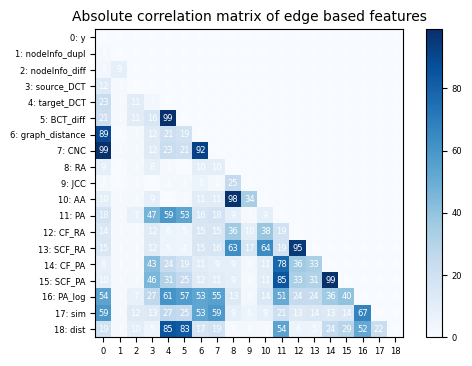

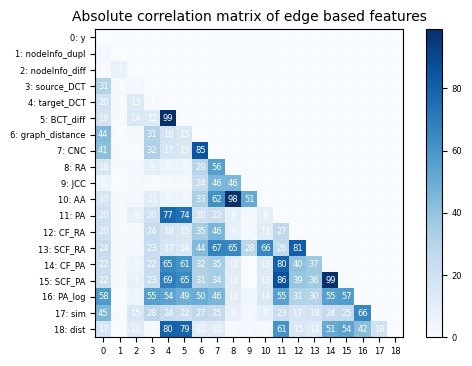

In [8]:
# plot correlation with target (first train, then validation)
for df in [train_tf, val_tf]:
    analyseData.plot_corr_matrix(df.iloc[:, 2:])

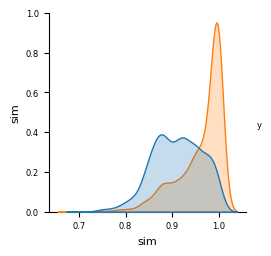

In [9]:
sns.pairplot(val_tf[["sim", "y"]], hue = "y")

### 3. Supervised Link Prediction

In [17]:
# prepare datasets for supervised methods, removing features highly correlated with target in train set but not in val set
X_trainval_sv  =  X_trainval[[col for col in X_trainval.columns  if col not in ["CNC", "graph_distance"]]]
X_train_sv  =  X_train[[col for col in X_train.columns  if col not in ["CNC", "graph_distance"]]]
X_val_sv  =  X_val[[col for col in X_val.columns  if col not in ["CNC", "graph_distance"]]]
X_test_sv  =  X_test[[col for col in X_test.columns  if col not in ["CNC", "graph_distance"]]]

# preparing predifined cv split for sklearn
val_fold = [0 if i in X_val.index else -1 for i in X_trainval.index]
ps = PredefinedSplit(val_fold)
ps.get_n_splits()

1

##### a) Logistic Regression

In [22]:
# logistic regression
clf = LogisticRegressionCV(max_iter = 10000, cv = ps)
clf.fit(X_trainval_sv, y_trainval)

# predict train
y_train_hat = clf.predict(X_trainval_sv)
# compute accuracy
acc_train = accuracy_score(y_trainval, y_train_hat)

# print performance
print(f"Acc train: {acc_train}")

Acc train: 0.7741997133301481


In [29]:
# predict test
y_test_hat = clf.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
0            2283
1            1215
dtype: int64

##### b) Random Forest & XGBoost

In [25]:
# search spaces
rdForest_params = {
                "n_estimators": tune.randint(10, 500),
                "max_depth": tune.randint(3, 10),
                "min_samples_split": tune.choice([2, 5, 10]),
                "min_samples_leaf": tune.choice([1, 2, 3, 4]),
                "max_features": tune.uniform(0.5, 1),
                "bootstrap": tune.choice([True, False])
            }

XGBoost_params = {
                "n_estimators": tune.randint(10, 500),
                "max_depth": tune.randint(3, 10),
                "min_child_weight": tune.uniform(1, 10),
                "colsample_bytree": tune.uniform(0.5, 1),
                "subsample": tune.uniform(0.6,1),
                "eta": tune.loguniform(1e-3, 1e-1)
            }

# loading models
rdForest_mdl = RandomForestClassifier()
XGBoost_mdl = XGBClassifier()

In [32]:
# tuning RandomForestClassifier
tune_search = TuneSearchCV(
    rdForest_mdl,
    rdForest_params,
    search_optimization="hyperopt",
    n_trials=100,
    cv=ps,
    scoring='accuracy',
    early_stopping=False,
    verbose=1
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.predict(X_trainval_sv)
acc_train = accuracy_score(y_trainval, y_trainval_hat)

print(f"Acc train: {acc_train}")

The TuneSearchCV best hyperparameters : {'n_estimators': 401, 'max_depth': 3, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 0.5714568590407575, 'bootstrap': False}
The TuneSearchCV best score : 0.7563306258958433
Acc train: 0.8633540372670807


In [33]:
# predict test
y_test_hat = tune_search.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
0            1801
1            1697
dtype: int64

In [34]:
# tuning XGBoostClassifier
tune_search = TuneSearchCV(
    XGBoost_mdl,
    XGBoost_params,
    search_optimization="hyperopt",
    n_trials=100,
    cv=ps,
    scoring='accuracy',
    early_stopping=False,
    verbose=1
)
tune_search.fit(X_trainval_sv, y_trainval)

# print tuning results
print(f'The TuneSearchCV best hyperparameters : {tune_search.best_params_}')
print(f'The TuneSearchCV best score : {tune_search.best_score_}')

# performance on train set
y_trainval_hat = tune_search.predict(X_trainval_sv)
acc_train = accuracy_score(y_trainval, y_trainval_hat)

print(f"Acc train: {acc_train}")

The TuneSearchCV best hyperparameters : {'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 9.328341173370958, 'colsample_bytree': 0.5317782300657089, 'subsample': 0.6408326594284804, 'eta': 0.0016593348867698162}
The TuneSearchCV best score : 0.7572861920688008
Acc train: 0.8658385093167702


In [35]:
# predict test
y_test_hat = tune_search.predict(X_test_sv)

# save test predictions
save_test = modeling.save_test_preds(test, test_tf, y_test_hat)
save_test.value_counts()

Predicted
0            1802
1            1696
dtype: int64